In [1]:
import numpy as np

from mintpy.objects import sensor
from mintpy.utils import ptime, readfile, utils as ut, writefile
from mintpy.objects.stack import timeseries
import datetime

In [45]:
def get_overlap_lalo(atr_list):
    """Find overlap area in lat/lon of geocoded files based on their metadata.
    Parameters: atr_list - list of dict, attribute dictionary of two input files in geo coord
    Returns:    S/N/W/E  - float, West/East/South/North in deg
    """
    S, N, W, E = None, None, None, None
    for i, atr in enumerate(atr_list):
        Si, Ni, Wi, Ei = ut.four_corners(atr)
        if i == 0:
            S, N, W, E = Si, Ni, Wi, Ei
        else:
            S = max(Si, S)
            N = min(Ni, N)
            W = max(Wi, W)
            E = min(Ei, E)

    return S, N, W, E

def get_design_matrix4horz_vert(los_inc_angle, los_az_angle, horz_az_angle=-90):
    """Design matrix G to convert asc/desc range displacement into horz/vert direction.
    Only asc + desc -> hz + up is implemented for now.

    Project displacement from LOS to Horizontal and Vertical components:
    Math for 3D:
        dLOS =   dE * sin(inc_angle) * sin(az_angle) * -1
               + dN * sin(inc_angle) * cos(az_angle)
               + dU * cos(inc_angle)
    Math for 2D:
        dLOS =   dH * sin(inc_angle) * cos(az_angle - az)
               + dV * cos(inc_angle)
        with dH_perp = 0.0
    This could be easily modified to support multiple view geometry
        (e.g. two adjacent tracks from asc & desc) to resolve 3D

    Parameters: los_inc_angle - 1D np.ndarray in size of (num_file), LOS incidence angle in degree.
                los_az_angle  - 1D np.ndarray in size of (num_file), LOS azimuth   angle in degree.
                horz_az_angle - float, azimuth angle for the horizontal direction of interest in degree.
                                Measured from the north with anti-clockwise direction as positive.
    Returns:    G             - 2D matrix in size of (num_file, 2)
    """
    num_file = los_inc_angle.shape[0]
    G = np.zeros((num_file, 2), dtype=np.float32)
    for i in range(num_file):
        G[i, 0] = np.sin(np.deg2rad(los_inc_angle[i])) * np.cos(np.deg2rad(los_az_angle[i] - horz_az_angle))
        G[i, 1] = np.cos(np.deg2rad(los_inc_angle[i]))

    return G
def asc_desc2horz_vert(dlos, los_inc_angle, los_az_angle, horz_az_angle=-90, step=20):
    """Decompose asc / desc LOS data into horz / vert data.
    Parameters: dlos          - 3D np.ndarray in size of (num_file, length, width), LOS displacement in meters.
                los_inc_angle - 1/3D np.ndarray in size of (num_file), length, width), LOS incidence angle in degree.
                los_az_angle  - 1/3D np.ndarray in size of (num_file), length, width), LOS azimuth   angle in degree.
                horz_az_angle - float, horizontal azimuth angle of interest in degree.
                step          - int, geometry step size
    Returns:    dhorz         - 2D np.ndarray in size of (length, width), horizontal displacement in meters.
                dvert         - 2D np.ndarray in size of (length, width), vertical   displacement in meters.
    """
    # initiate output
    (num_file, length, width) = dlos.shape
    dhorz = np.zeros((length, width), dtype=np.float32) * np.nan
    dvert = np.zeros((length, width), dtype=np.float32) * np.nan

    # 0D (constant) incidence / azimuth angle --> invert once for all pixels
    if los_inc_angle.ndim == 1:
        G = get_design_matrix4horz_vert(los_inc_angle, los_az_angle, horz_az_angle)
        print('decomposing asc/desc into horz/vert direction ...')
        dhv = np.dot(np.linalg.pinv(G), dlos.reshape(num_file, -1)).astype(np.float32)
        dhorz = dhv[0, :].reshape(length, width)
        dvert = dhv[1, :].reshape(length, width)

    # 2D incidence / azimuth angle --> invert [window-by-window to speed up]
    elif los_inc_angle.ndim == 3:
        num_row = np.ceil(length / step).astype(int)
        num_col = np.ceil(width / step).astype(int)

        print(f'decomposing asc/desc into horz/vert direction in windows of {step}x{step} ...')
        prog_bar = ptime.progressBar(maxValue=num_row)
        for i in range(num_row):
            y0, y1 = step * i, min(step * (i + 1), length)
            for j in range(num_col):
                x0, x1 = step * j, min(step * (j + 1), width)

                # calculate the median geometry for the local window
                med_los_inc_angle = np.nanmedian(los_inc_angle[:, y0:y1, x0:x1], axis=(1,2))
                med_los_az_angle  = np.nanmedian( los_az_angle[:, y0:y1, x0:x1], axis=(1,2))
                if np.all(~np.isnan(med_los_inc_angle)):

                    G = get_design_matrix4horz_vert(med_los_inc_angle, med_los_az_angle, horz_az_angle)
                    dhv = np.dot(np.linalg.pinv(G), dlos[:, y0:y1, x0:x1].reshape(num_file, -1))
                    dhorz[y0:y1, x0:x1] = dhv[0].reshape(y1-y0, x1-x0)
                    dvert[y0:y1, x0:x1] = dhv[1].reshape(y1-y0, x1-x0)

            prog_bar.update(i+1, suffix=f'{i+1}/{num_row}')
        prog_bar.close()

    else:
        raise ValueError(f'un-supported incidence angle matrix dimension ({los_inc_angle.ndim})!')

    return dhorz, dvert

In [7]:
#asc_ts_file=r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\timeseries_tropHgt_demErr_refEDPP.h5'
asc_ts_file=r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\corrected_ts.h5'
asc_20240811,asc_data_atr= readfile.read(asc_ts_file,datasetName='20240811');
#dsc_ts_file=r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Dsc\timeseries_tropHgt_demErr_refEDPP.h5'
dsc_ts_file=r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Dsc\corrected_ts.h5'
dsc_20240811,dsc_data_atr= readfile.read(dsc_ts_file,datasetName='20240811');

In [9]:
file_list = [asc_ts_file,dsc_ts_file];
geom_file = [r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\geometryGeo.h5',
             r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Dsc\geometryGeo.h5'];


In [11]:
def get_overlapping_dates(asc_dates,dsc_dates):
    asc_dates_set = set(asc_dates)
    desc_dates_set = set(dsc_dates)
    common_dates = asc_dates_set.intersection(desc_dates_set)
    return list(common_dates)
asc_dates = timeseries(asc_ts_file).get_date_list()
dsc_dates = timeseries(dsc_ts_file).get_date_list();
common_dates = sorted(get_overlapping_dates(asc_dates,dsc_dates))
print(asc_dates, dsc_dates);
print(common_dates);


['20220319', '20220331', '20220412', '20220424', '20220506', '20220518', '20220530', '20220611', '20220623', '20220705', '20220717', '20220729', '20220810', '20220822', '20220903', '20220915', '20220927', '20221009', '20221021', '20221102', '20221114', '20221126', '20221208', '20221220', '20230101', '20230113', '20230125', '20230206', '20230218', '20230302', '20230314', '20230326', '20230407', '20230419', '20230501', '20230513', '20230525', '20230606', '20230618', '20230630', '20230712', '20230724', '20230805', '20230817', '20230829', '20230910', '20230922', '20231004', '20231016', '20231028', '20231109', '20231121', '20231203', '20231215', '20231227', '20240108', '20240120', '20240201', '20240213', '20240225', '20240308', '20240320', '20240401', '20240413', '20240425', '20240507', '20240519', '20240531', '20240612', '20240706', '20240718', '20240730', '20240811', '20240823', '20240904'] ['20220106', '20220130', '20220211', '20220223', '20220307', '20220319', '20220331', '20220412', '2

In [13]:
# Adjust the code to find common and closest date
asc_datestamps = [datetime.datetime.strptime(date, "%Y%m%d") for date in asc_dates];
dsc_datestamps = [datetime.datetime.strptime(date, "%Y%m%d") for date in dsc_dates];
common_asc_dates = [];
common_dsc_dates = [];
for date in asc_datestamps:
    closest_date = min(dsc_datestamps, key=lambda b:abs(date-b));
    diff = date-closest_date;#diff = diff.astype(int)
    if diff < datetime.timedelta(10):
        common_asc_dates.append(date.strftime("%Y%m%d"));
        common_dsc_dates.append(closest_date.strftime("%Y%m%d"));
print(common_asc_dates,'\n',common_dsc_dates)  

#check for reference date issues
if common_asc_dates[0] != asc_data_atr['REF_DATE']:
    print('\n raise flag Asc. Check the dates you are merging');
elif common_dsc_dates[0] != dsc_data_atr['REF_DATE']:
    print('\n raise flag Dsc. Check the dates you are merging');

['20220319', '20220331', '20220412', '20220424', '20220506', '20220518', '20220530', '20220611', '20220623', '20220705', '20220717', '20220729', '20220810', '20220822', '20220903', '20220915', '20220927', '20221009', '20221021', '20221102', '20221114', '20221126', '20221208', '20221220', '20230101', '20230113', '20230125', '20230206', '20230218', '20230302', '20230314', '20230326', '20230407', '20230419', '20230501', '20230513', '20230525', '20230606', '20230618', '20230630', '20230712', '20230724', '20230805', '20230817', '20230829', '20230910', '20230922', '20231004', '20231016', '20231028', '20231109', '20231121', '20231215', '20231227', '20240108', '20240120', '20240201', '20240213', '20240225', '20240308', '20240320', '20240401', '20240425', '20240507', '20240519', '20240531', '20240612', '20240706', '20240718', '20240811'] 
 ['20220319', '20220331', '20220412', '20220424', '20220506', '20220518', '20220530', '20220611', '20220623', '20220705', '20220717', '20220729', '20220810', 

In [15]:
atr_list = [asc_data_atr, dsc_data_atr];
S, N, W, E = get_overlap_lalo(atr_list)
lat_step = float(atr_list[0]['Y_STEP'])
lon_step = float(atr_list[0]['X_STEP'])
length = int(round((S - N) / lat_step))
width  = int(round((E - W) / lon_step))
print(f'overlaping area in SNWE: {(S, N, W, E)}')

overlaping area in SNWE: (34.512486195, 36.24165217, -121.089118231, -118.23328604)


# Here adjust the Step Parameter for accuracy

In [47]:
def get_horz_vert(file_list,atr_list,geom_file,horz_az_angle,length, width,N,W,ds_names):
    print(ds_names)
    num_file = 2
    dlos = np.zeros((num_file, length, width), dtype=np.float32)
    los_inc_angle = np.zeros((num_file, length, width), dtype=np.float32)
    los_az_angle  = np.zeros((num_file, length, width), dtype=np.float32)
    
    for i, (atr, fname) in enumerate(zip(atr_list, file_list)):
        # overlap SNWE --> box to read for each specific file
        coord = ut.coordinate(atr)
        y0, x0 = coord.lalo2yx(N, W)
        box = (x0, y0, x0 + width, y0 + length)
    
        # read data
        dlos[i, :] = readfile.read(fname, box=box, datasetName=ds_names[i])[0];
        msg = f'{ds_names[i]} ' if ds_names[i] else ''
        print(f'read {msg} from file: {fname}')
    
    
        # read geometry
        
        los_inc_angle[i, :] = readfile.read(geom_file[i], box=box, datasetName='incidenceAngle')[0]
        los_az_angle[i, :]  = readfile.read(geom_file[i], box=box, datasetName='azimuthAngle')[0]
        print(f'read 2D LOS incidence / azimuth angles from file: {geom_file[i]}');
        
    
    dhorz, dvert = asc_desc2horz_vert(dlos, los_inc_angle, los_az_angle, horz_az_angle,step=20);
    return dhorz,dvert

####you can change the horz_azimuth_angle, measured postive anti clok wise. Hence E-W is -90;
horz_az_angle = -90.0;
horz_ts = np.zeros((len(common_asc_dates), length, width), dtype=np.float32)
vert_ts = np.zeros((len(common_asc_dates), length, width), dtype=np.float32)
for i,date in enumerate(common_asc_dates):
    horz_ts[i,:,:],vert_ts[i,:,:]  = get_horz_vert(file_list,atr_list,geom_file,horz_az_angle,length, width,N,W,[date,common_dsc_dates[i]]);
        
   


In [49]:
# coord = ut.coordinate(atr_list[0])
# y0, x0 = coord.lalo2yx(N, W)
# box1 = (x0, y0, x0 + width, y0 + length)
# coord = ut.coordinate(atr_list[1])
# y0, x0 = coord.lalo2yx(N, W)
# box2 = (x0, y0, x0 + width, y0 + length)
# # horz_dset = horz_ts[2,:,:];
# # vert_dset = vert_ts[2,:,:];
# horz_dset, vert_dset= get_horz_vert(file_list,atr_list,geom_file,horz_az_angle,length, width,N,W,[common_asc_dates[2],common_dsc_dates[2]]);
# asc_dset = readfile.read(file_list[0], box=box1, datasetName=common_asc_dates[2])[0]
# dsc_dset = readfile.read(file_list[1], box=box2, datasetName=common_dsc_dates[2])[0]
# asc_los_inc = readfile.read(geom_file[0], box=box1, datasetName='incidenceAngle')[0]
# dsc_los_inc = readfile.read(geom_file[1], box=box2, datasetName='incidenceAngle')[0]


['20220412', '20220412']
read 20220412  from file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\corrected_ts.h5
read 2D LOS incidence / azimuth angles from file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\geometryGeo.h5
read 20220412  from file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Dsc\corrected_ts.h5
read 2D LOS incidence / azimuth angles from file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Dsc\geometryGeo.h5
decomposing asc/desc into horz/vert direction in windows of 2x2 ...


C:\Users\bvarugu\AppData\Local\Temp\ipykernel_4328\1224404830.py:84: RuntimeWarning: All-NaN slice encountered
  med_los_inc_angle = np.nanmedian(los_inc_angle[:, y0:y1, x0:x1], axis=(1,2))
C:\Users\bvarugu\AppData\Local\Temp\ipykernel_4328\1224404830.py:85: RuntimeWarning: All-NaN slice encountered
  med_los_az_angle  = np.nanmedian( los_az_angle[:, y0:y1, x0:x1], axis=(1,2))


[==================================================] 1038/1038  465s /     9s 


C:\Users\bvarugu\AppData\Local\Temp\ipykernel_4328\2909300952.py:6: RuntimeWarning: Mean of empty slice
  combined_up_dset = np.nanmean(combined_up,axis=0);


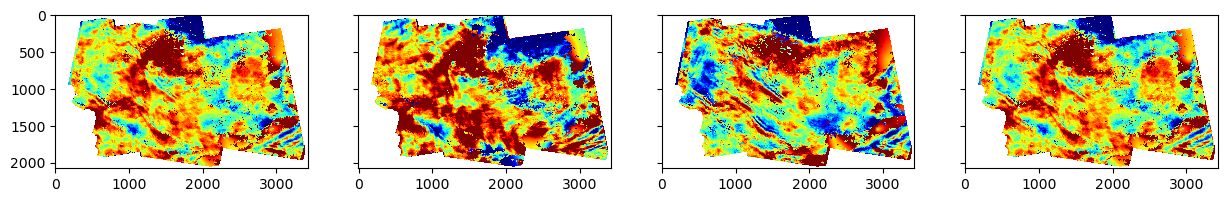

In [67]:
# up1 = (asc_dset)/(np.cos(np.deg2rad(asc_los_inc)));
# up2 = (dsc_dset)/(np.cos(np.deg2rad(dsc_los_inc)));
# combined_up =np.zeros((2, length, width), dtype=np.float32);
# combined_up[0,:,:] =up1;
# combined_up[1,:,:] =up2;
# combined_up_dset = np.nanmean(combined_up,axis=0);
# #up2 = (asc_dset)/(np.cos(np.deg2rad(asc_los_inc)));
# #import matplotlib.pyplot as plt
# fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(15,10),sharey=True);

# vmin= -0.02;vmax=0.02;
# im1 = ax1.imshow(np.ma.masked_where(np.isnan(vert_dset), vert_dset), cmap='jet', vmin=vmin, vmax=vmax,interpolation='nearest');
# im2 = ax2.imshow(np.ma.masked_where(np.isnan(vert_dset), up1), cmap='jet', vmin=vmin, vmax=vmax,interpolation='nearest');
# im3 = ax3.imshow(np.ma.masked_where(np.isnan(vert_dset),up2), cmap='jet', vmin=vmin, vmax=vmax,interpolation='nearest');
# im4 = ax4.imshow(np.ma.masked_where(np.isnan(vert_dset),combined_up_dset), cmap='jet', vmin=vmin, vmax=vmax,interpolation='nearest');



In [9]:
vertfile_outname = r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_vert_GNSS_corrected.h5'
horzfile_outname = r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_horz_GNSS_corrected.h5'

atr = atr_list[0].copy()
atr['FILE_TYPE'] = 'timeseries'

atr['WIDTH']  = str(width)
atr['LENGTH'] = str(length)
atr['X_STEP'] = str(lon_step)
atr['Y_STEP'] = str(lat_step)
atr['X_FIRST'] = str(W)
atr['Y_FIRST'] = str(N)

    # update REF_X/Y
ref_lat, ref_lon = float(atr['REF_LAT']), float(atr['REF_LON'])
[ref_y, ref_x] = ut.coordinate(atr).geo2radar(ref_lat, ref_lon)[0:2]
atr['REF_Y'] = int(ref_y)
atr['REF_X'] = int(ref_x)
num_date = len(common_dates);
common_dates = np.array(common_dates, dtype=np.bytes_)
num_date = len(common_dates);
# use ref_file for time-series file writing
vert_ts_dict = {
    "date"       : common_dates,
    "timeseries" : vert_ts,
}
horz_ts_dict = {
    "date"       : common_dates,
    "timeseries" : horz_ts,
}
writefile.write(vert_ts_dict,vertfile_outname,metadata=atr);
writefile.write(horz_ts_dict,horzfile_outname,metadata=atr)

create HDF5 file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_vert_GNSS_corrected.h5 with w mode
create dataset /date       of |S8        in size of (70,)                with compression=None
create dataset /timeseries of float32    in size of (70, 2075, 3427)     with compression=None
finished writing to C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_vert_GNSS_corrected.h5
create HDF5 file: C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_horz_GNSS_corrected.h5 with w mode
create dataset /date       of |S8        in size of (70,)                with compression=None
create dataset /timeseries of float32    in size of (70, 2075, 3427)     with compression=None
finished writing to C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\timeseries_horz_GNSS_corrected.h5


'C:\\Users\\bvarugu\\Documents\\Lamont_Earthquake\\ARIA_products\\timeseries_horz_GNSS_corrected.h5'